This solution is for Kaggle competition dedicated to prediction of obesity risk. Data may be found by link https://www.kaggle.com/competitions/playground-series-s4e2/data 

This data has very clean content, does not have any missing values. So, work with this data is simple, and even default models perform great result.

Importing libraries:

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import optuna
from sklearn.model_selection import cross_validate

c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Uploading files:

In [4]:
train_data = pd.read_csv('C:/Users/alexa/Downloads/playground-series-s4e2/train.csv')
test_data = pd.read_csv('C:/Users/alexa/Downloads/playground-series-s4e2/test.csv')

In [6]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Description of Features:
Gender, Age, Height, Weight are physical attributes, family_history_with_overweight points out to familiarity with obesity, FAVC = Frequent consumption of high caloric food, FCVC = Frequency of consumption of vegetables, NCP = Number of main meals, CAEC = Consumption of food between meals, SMOKE = tobacco usage, CH20 = Consumption of water daily, SCC = Calories consumption monitoring, FAF = Physical activity frequency, TUE = Time using technology devices, CALC = Consumption of alcohol, MTRANS = Transportation used everyday.

Creating functions transforming dataset for machine learning models

It is obvious that categorical features 'CAEC', 'CALC', 'NObeyesdad' have gradation, and therefore can be expressed as an ordered series of natural numbers.

I deleted one columns which got in dummy variables, it's Ok to save it because I don't use linear regression, but gradient boostings and decision trees work in full collinearity. In this case I did it because this gives betterr result.

In [7]:
def data_frame_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop('id', axis=1)
    df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
    df['Age'] = df['Age'].astype(int)
    df['Height'] = df['Height'].apply(lambda x: round(x*100, ndigits=0)).astype(int)
    df['Weight'] = df['Weight'].apply(lambda x: round(x, ndigits=0)).astype(int)
    df['family_history_with_overweight'] = df['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
    df['FAVC'] = df['FAVC'].replace({'yes': 1, 'no': 0})
    df['CAEC'] = df['CAEC'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['SMOKE'] = df['SMOKE'].replace({'yes': 1, 'no': 0})
    df['SCC'] = df['SCC'].replace({'yes': 1, 'no': 0})
    df['CALC'] = df['CALC'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df = pd.get_dummies(df, columns=['MTRANS'], prefix='MTRANS', dtype=int)
    df = df.drop('MTRANS_Public_Transportation', axis=1)
    if 'NObeyesdad' in df.columns.tolist():
        df['NObeyesdad'] = df['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 
             'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})
    return df

def get_target(df):
    target = df.NObeyesdad
    df = df.drop('NObeyesdad', axis=1)

    return df, target

In [8]:
X, y = get_target(data_frame_transform(train_data))

In [6]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Walking
0,1,24,170,82,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,0,0,0,0
1,0,18,156,57,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,1,0,0,0
2,0,18,171,50,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,0,0,0,0
3,0,20,171,131,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,0,0,0,0
4,1,31,191,94,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,0,0,0,0


In [7]:
y.head()

0    3
1    1
2    0
3    6
4    3
Name: NObeyesdad, dtype: int64

We see that target values are mostly balanced, so we do not need to use some tools for processing imbalanced values.

In [8]:
y.value_counts()

NObeyesdad
6    4046
5    3248
1    3082
4    2910
0    2523
3    2522
2    2427
Name: count, dtype: int64

Let's visualize data.

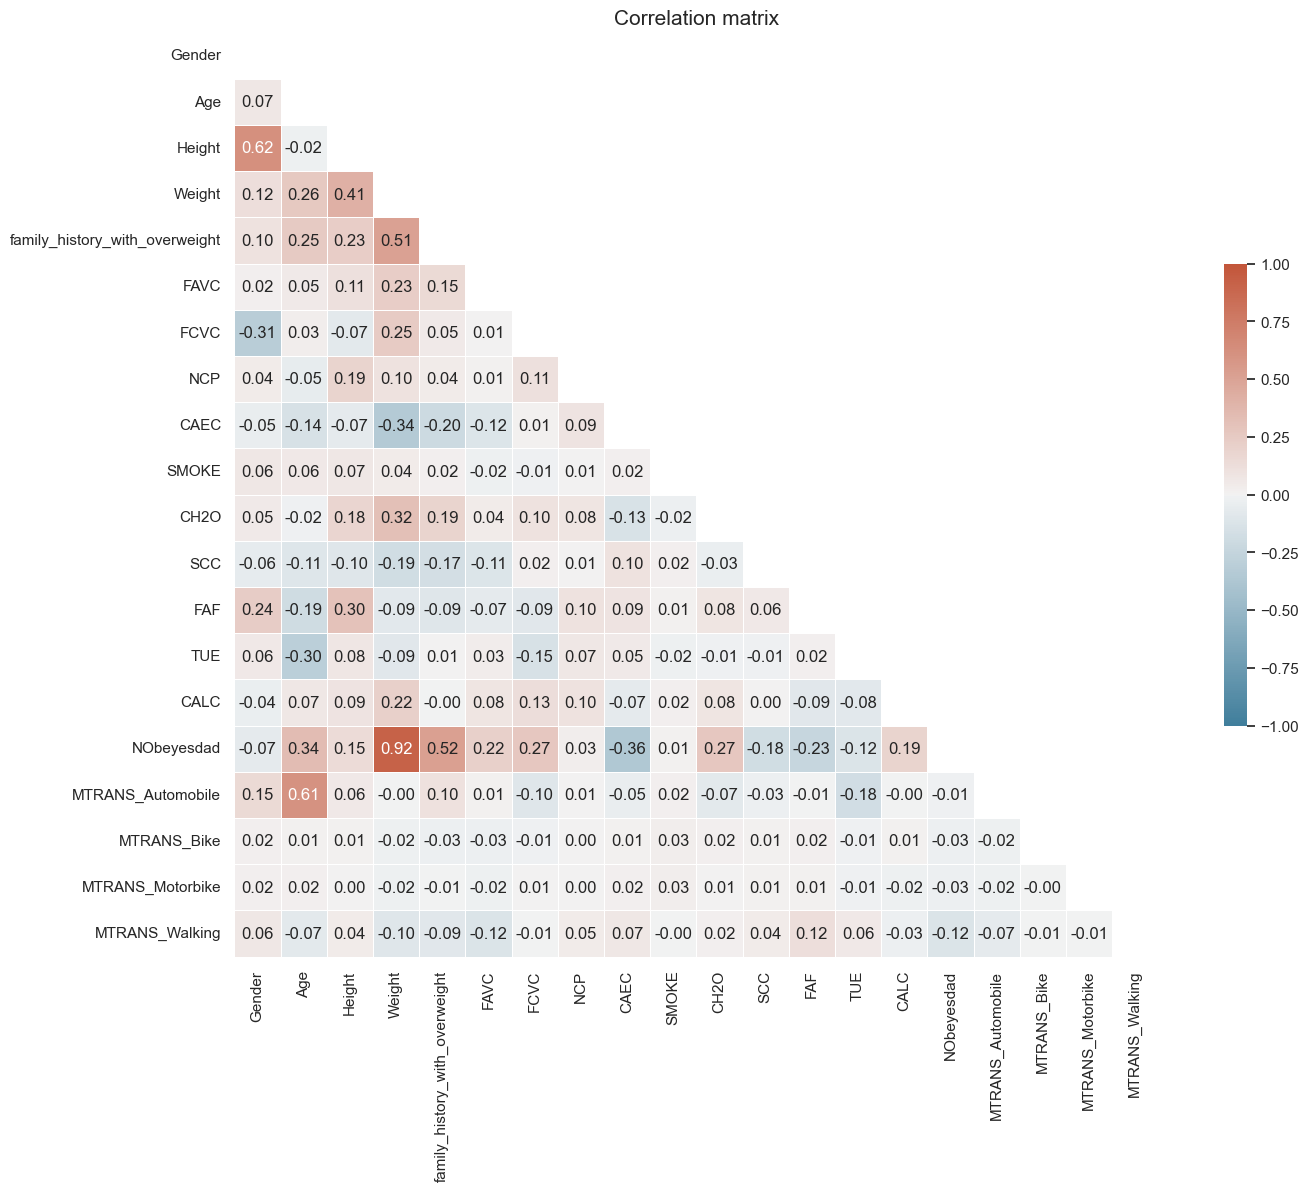

In [9]:
df_to_visualize = data_frame_transform(train_data)
sns.set_theme(style="white")
corr = df_to_visualize.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(17, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation matrix', fontdict={'fontsize': 15})
plt.show()

Obviously, a person's weight has the greatest impact on the target.

In [14]:
def plot_for_column(column):

    if len(X[column].unique()) <=7:
        sns.histplot(X[column], color='skyblue')
    else:
        sns.histplot(X[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

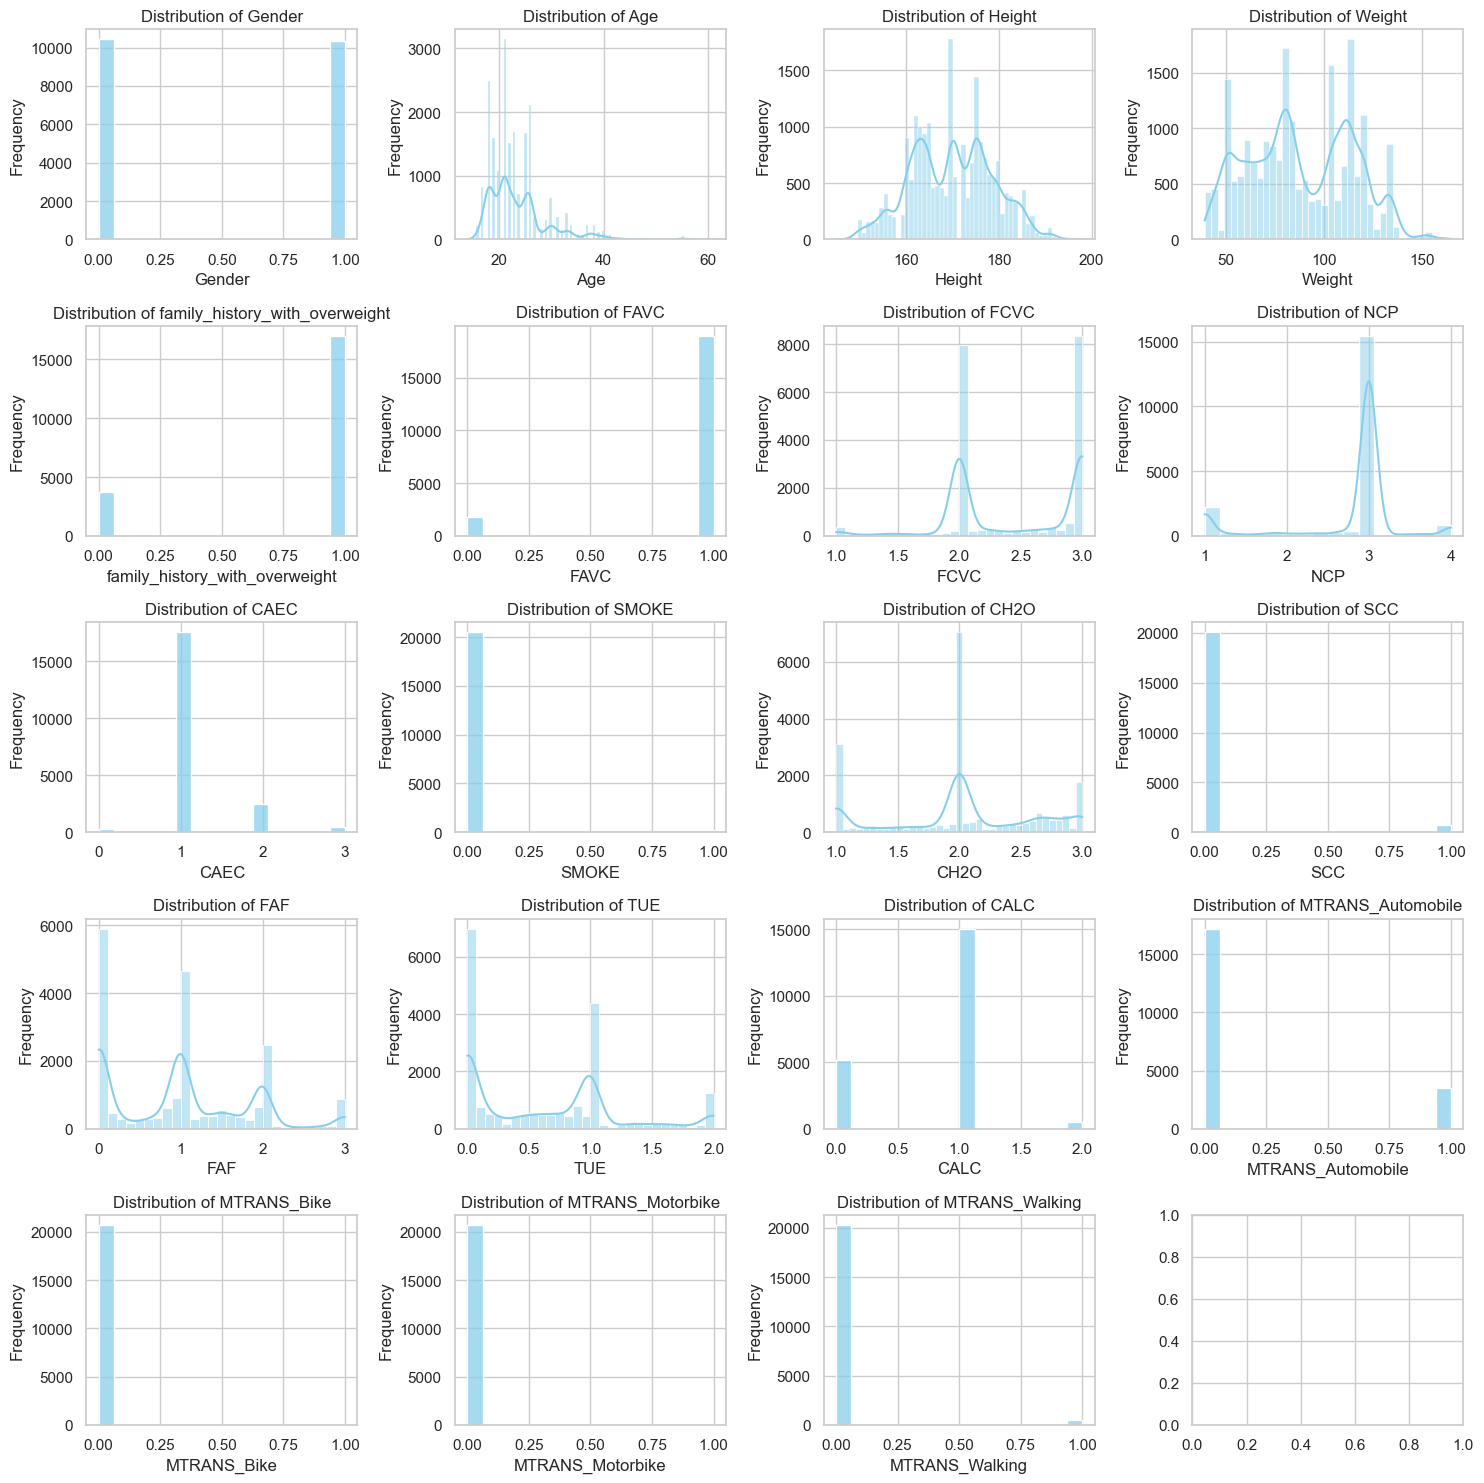

In [15]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(5, 4, figsize=(15,15))
for i, item in enumerate(X.columns.tolist()):
    plt.subplot(5, 4, i+1)
    plot_for_column(item)
           
plt.tight_layout()
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
def pipeline_for_optuna_LightGBM(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.07, 0.1)

    pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('model', LGBMClassifier(
                                num_leaves=num_leaves, 
                                max_depth=max_depth, 
                                learning_rate=learning_rate, 
                                n_estimators=n_estimators
                                ))
                            ])
    
    result = cross_validate(pipeline, X, y, cv=5)['test_score'].mean()
    return result

In [ ]:
study_ = optuna.create_study(direction='maximize')
study_.optimize(pipeline_for_optuna_LightGBM, n_trials=100)

best_params = study_.best_params
best_accuracy = study_.best_value

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_accuracy)

Results:

The best parameters for LightGBMlassifier: {'max_depth': 6, 'n_estimators': 96, 'num_leaves': 15, 'learning_rate': 0.07359481786892615}

Accuracy using cross validation: 0.9061569768224478

In [23]:
def pipeline_for_optuna_forest(trial):
    
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 50)

    pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('model', DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf))
                            ])
    
    result = cross_validate(pipeline, X, y, cv=5)['test_score'].mean()
    return result

In [ ]:
_study_ = optuna.create_study(direction='maximize')
_study_.optimize(pipeline_for_optuna_forest, n_trials=100)

best_params = _study_.best_params
best_accuracy = _study_.best_value

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_accuracy)

In [17]:
def pipeline_for_optuna_XGB(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    max_leaves = trial.suggest_int('max_leaves', 10, 100)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.07, 0.1)
    gamma = trial.suggest_float('gamma', 0.3, 1.0)

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', XGBClassifier(
            max_depth=max_depth, 
            n_estimators=n_estimators, 
            max_leaves=max_leaves, 
            learning_rate=learning_rate, 
            gamma=gamma
        ))
    ])

    result = cross_validate(pipeline, X, y, cv=5)['test_score'].mean()
    return result

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(pipeline_for_optuna_XGB, n_trials=100)

best_params = study.best_params
best_accuracy = study.best_value

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_accuracy)

Results:

The best parameters for XGBClassifier: {'max_depth': 10, 'n_estimators': 81, 'max_leaves': 99, 'learning_rate': 0.08090510188810456, 'gamma': 0.843985921410168}

Accuracy using cross validation: 0.9051451260206583

Making function for getting result (DataFrame with predictions and column 'id'). Using stacking

In [33]:
def get_result(X, y, X_test):

    pipeline_1 = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', LGBMClassifier(
            max_depth=6, 
            n_estimators=96, 
            max_leaves=15, 
            learning_rate=0.07359481786892615
        ))
    ])

    pipeline_2 = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', XGBClassifier(
            max_depth=10, 
            n_estimators=81, 
            max_leaves=99, 
            learning_rate=0.08090510188810456, 
            gamma= 0.843985921410168
        ))
    ])

    pipeline_3 = Pipeline(steps=[('scaler', StandardScaler()), 
                                 ('model', DecisionTreeClassifier(max_depth=10, min_samples_leaf=13))])

    pipeline_1.fit(X, y)
    pipeline_2.fit(X, y)
    pipeline_3.fit(X, y)
    pred_1 = pipeline_1.predict(X_test)
    pred_2 = pipeline_2.predict(X_test)
    pred_3 = pipeline_3.predict(X_test)
    pred = np.round(np.vstack((pred_1,pred_2, pred_3)).max(axis=0)).astype(int)
    testy = pd.DataFrame(data=pred, columns=['NObeyesdad'])
    testy = pd.concat((test_data.id, testy), axis=1)
    testy['NObeyesdad'] = testy['NObeyesdad'].replace({0: 'Insufficient_Weight', 1: 'Normal_Weight', 2: 'Overweight_Level_I', 
             3: 'Overweight_Level_II', 4: 'Obesity_Type_I', 5: 'Obesity_Type_II', 6: 'Obesity_Type_III'})
    return testy

Saving result and submitting it

In [ ]:
testX = data_frame_transform(test_data)
submission = get_result(X, y, testX)
submission.to_csv('C:/Users/alexa/Downloads/playground-series-s4e2/submission.csv', index=False)

Resulting score of this model is 0.90859